In [33]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# Question 1: Which year had the highest number of additions?

In [231]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

In [232]:
tables = pd.read_html(url)

In [233]:
sp500_table = tables[0]

In [234]:
df_constituents = sp500_table[['Symbol', 'Security', 'Date added']].copy()

In [235]:
df_constituents.rename(columns={'Symbol': 'Ticker', 'Security': 'Name', 'Date added': 'DateAdded'}, inplace=True)

In [238]:
df_constituents.tail()

,Ticker,Name,DateAdded
498,XYL,Xylem Inc.,2011-11-01
499,YUM,Yum! Brands,1997-10-06
500,ZBRA,Zebra Technologies,2019-12-23
501,ZBH,Zimmer Biomet,2001-08-07
502,ZTS,Zoetis,2013-06-21


In [239]:
df_constituents['YearAdded'] = pd.to_datetime(df_constituents['DateAdded'], errors='coerce').dt.year

In [240]:
df_constituents['YearAdded'].value_counts().head()

YearAdded
1957    53
2017    23
2016    23
2019    22
2008    17
Name: count, dtype: int64

The answer is 2017.

# Question 2: How many indexes (out of 10) have better year-to-date returns than the US (S&P 500) as of May 1, 2025?

In [241]:
tickers = {
    '^GSPC': 'S&P 500 (US)',
    '000001.SS': 'Shanghai Composite (China)',
    '^HSI': 'HANG SENG INDEX (Hong Kong)',
    '^AXJO': 'S&P/ASX 200 (Australia)',
    '^NSEI': 'Nifty 50 (India)',
    '^GSPTSE': 'S&P/TSX Composite (Canada)',
    '^GDAXI': 'DAX (Germany)',
    '^FTSE': 'FTSE 100 (UK)',
    '^N225': 'Nikkei 225 (Japan)',
    '^MXX': 'IPC Mexico (Mexico)',
    '^BVSP': 'Ibovespa (Brazil)'
}

In [242]:
ytd_start_date = '2025-01-01'
end_date = '2025-05-01'

In [243]:
data = yf.download(tickers=list(tickers.keys()), start=ytd_start_date, end=pd.to_datetime(end_date) + pd.Timedelta(days=1), progress=False)

In [244]:
price_data = data[data.index >= pd.to_datetime(ytd_start_date)]

In [246]:
price_data['Close'].head()

Ticker,000001.SS,^AXJO,^BVSP,^FTSE,^GDAXI,^GSPC,^GSPTSE,^HSI,^MXX,^N225,^NSEI
Date,,,,,,,,,,,
2025-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23742.900391
2025-01-02,3262.561035,8201.200195,120125.0,8260.099609,20024.660156,5868.549805,24898.000000,19623.320312,49765.199219,NaN,24188.650391
2025-01-03,3211.429932,8250.500000,118533.0,8224.000000,19906.080078,5942.470215,25073.500000,19760.269531,48957.238281,NaN,24004.750000
2025-01-06,3206.923096,8288.500000,120022.0,8249.700195,20216.189453,5975.379883,24999.800781,19688.289062,49493.558594,39307.050781,23616.050781
2025-01-07,3229.644043,8285.099609,121163.0,8245.299805,20340.570312,5909.029785,24929.900391,19447.580078,50085.500000,40083.300781,23707.900391


In [247]:
start_prices = price_data['Open'].apply(lambda col: col.dropna().iloc[0])

In [248]:
end_prices = price_data['Close'].apply(lambda col: col.dropna().iloc[-1])

In [249]:
(((end_prices / start_prices)-1)*100).rename(index=tickers).sort_values(ascending=False)

Ticker
IPC Mexico (Mexico)            13.410242
DAX (Germany)                  12.919244
Ibovespa (Brazil)              12.291014
HANG SENG INDEX (Hong Kong)    10.969905
FTSE 100 (UK)                   3.961823
Nifty 50 (India)                2.946777
S&P/TSX Composite (Canada)     -0.103136
S&P/ASX 200 (Australia)        -0.165459
Shanghai Composite (China)     -2.058220
S&P 500 (US)                   -5.067025
Nikkei 225 (Japan)             -8.744735
dtype: float64

The answer is 9.

# Question 3: Calculate the median duration (in days) of significant market corrections in the S&P 500 index.

In [250]:
sp500 = yf.download("^GSPC", start="1950-01-01", end=datetime.now().strftime("%Y-%m-%d"))

[*********************100%***********************]  1 of 1 completed


In [251]:
sp500.columns = sp500.columns.get_level_values(0)

In [252]:
sp500.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000
1950-01-04,16.85,16.85,16.85,16.85,1890000
1950-01-05,16.93,16.93,16.93,16.93,2550000
1950-01-06,16.98,16.98,16.98,16.98,2010000
1950-01-09,17.08,17.08,17.08,17.08,2520000


In [253]:
high = sp500['Close'].copy() # high = sp500['High'].copy()

In [254]:
low = sp500['Close'].copy() # low = sp500['Low'].copy()

In [255]:
cummax = high.expanding().max()

In [256]:
ath_mask = np.isclose(high, cummax, rtol=1e-10)

In [257]:
ath_points = high[ath_mask].copy()

<Axes: xlabel='Date'>

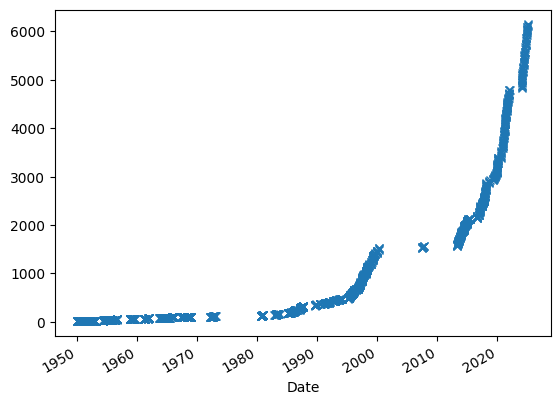

In [258]:
ath_points.plot(marker='x', ls='None')

In [259]:
corrections = []

for i in range(len(ath_points) - 1):
    start_date = ath_points.index[i]
    end_date = ath_points.index[i + 1]
    start_price = ath_points.iloc[i]
    end_price = ath_points.iloc[i + 1]

    mask = (low.index >= start_date) & (low.index <= end_date)
    period_prices = low[mask]
    
    min_price = period_prices.min()
    min_date = period_prices.idxmin()

    drawdown_pct = (start_price - min_price) / start_price * 100

    if drawdown_pct > 5.0:
        duration_days = (min_date - start_date).days
        
        corrections.append({
            'start_date': start_date,
            'end_date': end_date,
            'start_price': start_price,
            'end_price': end_price,
            'min_price': min_price,
            'min_date': min_date,
            'drawdown_pct': drawdown_pct,
            'duration_days': duration_days
        })
    
    corrections_df = pd.DataFrame(corrections)


In [260]:
corrections_df.sort_values(by='drawdown_pct', ascending=False).head(10)

,start_date,end_date,start_price,end_price,min_price,min_date,drawdown_pct,duration_days
56,2007-10-09,2013-03-28,1565.150024,1569.189941,676.530029,2009-03-09,56.775388,517
54,2000-03-24,2007-05-30,1527.459961,1530.229980,776.760010,2002-10-09,49.146948,929
24,1973-01-11,1980-07-17,120.239998,121.440002,62.279999,1974-10-03,48.203593,630
22,1968-11-29,1972-03-06,108.370003,108.769997,69.290001,1970-05-26,36.061641,543
65,2020-02-19,2020-08-18,3386.149902,3389.780029,2237.399902,2020-03-23,33.924960,33
35,1987-08-25,1989-07-26,336.769989,338.049988,223.919998,1987-12-04,33.509515,101
15,1961-12-12,1963-09-03,72.639999,72.660004,52.320000,1962-06-26,27.973568,196
27,1980-11-28,1982-11-03,140.520004,142.869995,102.419998,1982-08-12,27.113582,622
68,2022-01-03,2024-01-19,4796.560059,4839.810059,3577.030029,2022-10-12,25.425097,282
18,1966-02-09,1967-05-04,94.059998,94.320000,73.199997,1966-10-07,22.177335,240


In [261]:
corrections_df['duration_days'].describe()

count     71.000000
mean     113.098592
std      179.073341
min        7.000000
25%       21.500000
50%       39.000000
75%       89.000000
max      929.000000
Name: duration_days, dtype: float64

The answer is 39.

# Question 4: Calculate the median 2-day percentage change in stock prices following positive earnings surprises days.

In [197]:
amazon = pd.read_csv("ha1_Amazon.csv", delimiter=';') 

In [198]:
amazon.tail()

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise (%)
112,AMZN,"Amazon.com, Inc.","April 27, 1998 at 12 AM EDT",-,-,+13.92
113,AMZN,"Amazon.com, Inc.","January 22, 1998 at 12 AM EST",-,-,+11.41
114,AMZN,"Amazon.com, Inc.","October 27, 1997 at 12 AM EST",-,-,+13.29
115,AMZN,"Amazon.com, Inc.","July 10, 1997 at 12 AM EDT",-,-,+13.33
116,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
# amazon['Surprise (%)'] = amazon['Surprise (%)'].replace('-', np.nan)
# amazon['Surprise (%)'] = amazon['Surprise (%)'].str.replace('+', '', regex=False)
# amazon['Surprise (%)'] = amazon['Surprise (%)'].astype(float)

In [200]:
amazon = amazon.dropna(subset=['Earnings Date']).copy()
amazon['Date'] = pd.to_datetime(amazon['Earnings Date'].str.extract(r'^([A-Za-z]+\s+\d{1,2},\s+\d{4})').iloc[:, 0], errors='coerce')
amazon['Date'] = amazon['Date'].dt.strftime('%Y-%m-%d')

In [201]:
amazon['EPS Estimate'] = amazon['EPS Estimate'].replace('-', np.nan)
amazon['Reported EPS'] = amazon['Reported EPS'].replace('-', np.nan)
amazon.loc[amazon['EPS Estimate'].str.contains(r'\?', na=False), 'EPS Estimate'] = np.nan
amazon.loc[amazon['Reported EPS'].str.contains(r'\?', na=False), 'Reported EPS'] = np.nan
amazon['EPS Estimate'] = amazon['EPS Estimate'].astype(float)
amazon['Reported EPS'] = amazon['Reported EPS'].astype(float)

In [202]:
amazon['positive_earnings_surprise'] = amazon['Reported EPS'] > amazon['EPS Estimate']

In [203]:
(amazon['positive_earnings_surprise'] == True).sum()

np.int64(33)

In [204]:
amazon[amazon['positive_earnings_surprise'] == True]

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise (%),Date,positive_earnings_surprise
8,AMZN,"Amazon.com, Inc.","April 30, 2024 at 4 PM EDT",0.83,0.98,+17.91,2024-04-30,True
9,AMZN,"Amazon.com, Inc.","February 1, 2024 at 4 PM EST",0.80,1.00,+24.55,2024-02-01,True
10,AMZN,"Amazon.com, Inc.","October 26, 2023 at 4 PM EDT",0.58,0.94,+60.85,2023-10-26,True
11,AMZN,"Amazon.com, Inc.","August 3, 2023 at 4 PM EDT",0.35,0.65,+85.73,2023-08-03,True
12,AMZN,"Amazon.com, Inc.","April 27, 2023 at 4 PM EDT",0.21,0.31,+46.36,2023-04-27,True
13,AMZN,"Amazon.com, Inc.","February 2, 2023 at 4 PM EST",0.18,0.25,+42.56,2023-02-02,True
15,AMZN,"Amazon.com, Inc.","July 28, 2022 at 4 PM EDT",0.14,0.18,+24.9,2022-07-28,True
17,AMZN,"Amazon.com, Inc.","February 3, 2022 at 4 PM EST",0.18,0.29,+62.48,2022-02-03,True
19,AMZN,"Amazon.com, Inc.","July 29, 2021 at 4 PM EDT",0.62,0.76,+22.91,2021-07-29,True
20,AMZN,"Amazon.com, Inc.","April 29, 2021 at 4 PM EDT",0.48,0.79,+65.48,2021-04-29,True


In [220]:
amazon_yf = yf.download("AMZN", start="1950-01-01", end=datetime.now().strftime("%Y-%m-%d"))

[*********************100%***********************]  1 of 1 completed


In [221]:
amazon_yf = amazon_yf.reset_index()
amazon_yf.columns = amazon_yf.columns.get_level_values(0)
amazon_yf = amazon_yf[['Date', 'Close']].copy()

In [224]:
amazon_yf['Close_Day1'] = amazon_yf['Close'].shift(1) 
amazon_yf['Close_Day3'] = amazon_yf['Close'].shift(-1)

amazon_yf['2_day_return'] = amazon_yf['Close_Day3'] / amazon_yf['Close_Day1'] - 1
amazon_yf = amazon_yf.dropna(subset=['2_day_return', 'Date'])

amazon_yf['Date'] = amazon_yf['Date'].dt.strftime('%Y-%m-%d')

In [225]:
amazon_yf.head()

Price,Date,Close,Close_Day1,Close_Day3,2_day_return
1,1997-05-16,0.086458,0.097917,0.085417,-0.127659
2,1997-05-19,0.085417,0.086458,0.081771,-0.054211
3,1997-05-20,0.081771,0.085417,0.071354,-0.164639
4,1997-05-21,0.071354,0.081771,0.069792,-0.146494
5,1997-05-22,0.069792,0.071354,0.075000,0.051097


In [226]:
merged = pd.merge(amazon, amazon_yf, on='Date', how='inner')

In [227]:
merged.head()

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise (%),Date,positive_earnings_surprise,Close,Close_Day1,Close_Day3,2_day_return
0,AMZN,"Amazon.com, Inc.","May 1, 2025 at 4 PM EDT",NaN,NaN,+16.74,2025-05-01,False,190.199997,184.419998,189.979996,0.030149
1,AMZN,"Amazon.com, Inc.","February 6, 2025 at 4 PM EST",NaN,NaN,+24.47,2025-02-06,False,238.830002,236.169998,229.149994,-0.029724
2,AMZN,"Amazon.com, Inc.","October 31, 2024 at 4 PM EDT",NaN,NaN,+25.17,2024-10-31,False,186.399994,192.729996,197.929993,0.026981
3,AMZN,"Amazon.com, Inc.","August 1, 2024 at 4 PM EDT",NaN,NaN,+22.58,2024-08-01,False,184.070007,186.979996,167.899994,-0.102043
4,AMZN,"Amazon.com, Inc.","April 30, 2024 at 4 PM EDT",0.83,0.98,+17.91,2024-04-30,True,175.000000,180.960007,179.000000,-0.010831


In [228]:
(merged[merged['positive_earnings_surprise'] == True]['2_day_return'] * 100).shape  #.median()

(33,)

In [229]:
(merged[merged['positive_earnings_surprise'] == True]['2_day_return'] * 100).median()

np.float64(2.5702644458225343)

The answer is 2.6.

# Question 5: Brainstorm potential idea for your capstone project

Build an algorithmic trading strategy that predicts sector rotation patterns in the US stock market using economic indicators and basic sentiment analysis from freely available news data.

# Question 6: Investigate new metrics

The VIX, often referred to as the “fear index,” measures market expectations of near-term volatility conveyed by S&P 500 option prices. It provides insight into investor sentiment and potential risk-off behavior.

Bond yields influence the discount rate used in stock valuation models. A rising 10Y yield can signal tightening financial conditions, affecting equities, especially growth stocks.

In [ ]:
- unemployment data and open positions in different sectors
- industrial production
- It would be interesting to monitor social media mentions with sentiment analysis. How many posts are positive and how many negative and how does this change over time.